In [57]:
import os
import random

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.feature_selection import RFECV

from keras import utils
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

%matplotlib inline

In [2]:
df_Xtrain = pd.read_csv('../input/X_train.csv')
df_ytrain = pd.read_csv('../input/y_train.csv')
df_Xtest = pd.read_csv('../input/X_test.csv')

In [3]:
df_Xtrain.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
df_Xtrain.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [5]:
df_Xtrain.shape

(487680, 13)

In [6]:
df_Xtrain[df_Xtrain['series_id']==1].shape

(128, 13)

In [7]:
df_ytrain.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [8]:
df_ytrain.shape

(3810, 3)

In [9]:
df_Xtest.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In [10]:
df_Xtest.shape

(488448, 13)

## Data Preprocessing

In [12]:
#checking if there are missing data
df_Xtrain.isnull().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [13]:
#checking duplicates
df_Xtrain.duplicated().value_counts()

False    487680
dtype: int64

Summary: no missing values, no duplicates

# Data Exploration

In [14]:
#merge X_train and y_train datasets to explore data
df_explore = pd.merge(df_Xtrain, df_ytrain,  on='series_id', how='inner')
df_explore.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


In [15]:
robot_stats = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
              'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
              'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

In [16]:
#convert surface variable from plain object type into a categorical type
#ordered according to their proportions in the dataset
surface_types = df_explore['surface'].unique()
surfaces = pd.api.types.CategoricalDtype(ordered = True, categories = surface_types)
df_explore['surface'] = df_explore['surface'].astype(surfaces)
targets = df_explore['surface'].value_counts().index
targets

CategoricalIndex(['concrete', 'soft_pvc', 'wood', 'tiled', 'fine_concrete',
                  'hard_tiles_large_space', 'soft_tiles', 'carpet',
                  'hard_tiles'],
                 categories=['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc', 'hard_tiles_large_space', 'carpet', 'hard_tiles', ...], ordered=True, dtype='category')

## Surfaces

### Surfaces countplot

In [18]:
# create a list of tick positions by computing the length of the longest bar in terms of proportion
n_surface = df_ytrain['surface'].shape[0]
type_counts = df_ytrain['surface'].value_counts()
max_type_count = type_counts.max()
max_prop = max_type_count/n_surface
max_prop

0.20446194225721784

In [19]:
# create evenly spaced proportioned values between 0 and max in steps of 2%
tick_props = np.arange(0, max_prop, 0.02)
tick_props

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ])

In [20]:
# create evenly spaced proportioned values between 0 and max in steps of 2%
tick_props = np.arange(0, max_prop, 0.02)
tick_props

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ])

In [21]:
# format tick labels
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

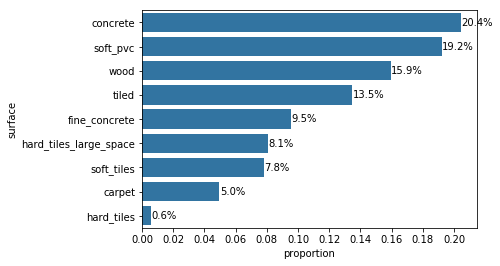

In [22]:
base_color = sns.color_palette()[0]

sns.countplot(data = df_ytrain, y = 'surface', color=base_color, order=targets);
plt.xticks(tick_props*n_surface, tick_names);
plt.xlabel('proportion');
for i in range(type_counts.shape[0]):
    #X position just after the end of the bar:
    count = type_counts[i]
    #Y position which starts at 0 and increments with the loop
    pct_string = '{:0.1f}%'.format(100*count/n_surface)
    # the string to be printed, the percentage, centered vertically with VA parameter
    plt.text(count+1, i, pct_string, va = 'center');

## Summary: Surfaces
So the most common surfaces that we have recordings are concrete (20%) and soft_pvc (19%). Then we have subcategory of concrete (fine_concrete - 9.5%) and different type of tiles (hard, hard/large_space, soft, tiled = ca. 30%). So the whole picture of surfaces looks like this (aggregated by all subtypes): concrete = ca. 30%, tiles = ca. 30%, soft_pvc = 19%, wood = 16%, carpet = 5%. <br>
The most difficult part will be probably to *differentiate between different tiles types*, because they together constitute a large part of recordings with subtle differences and so may increase the number of false positives.

## Surfaces Summary table: by group_id and series_id

In [24]:
#adding unique group_id list as column
surface = df_ytrain.groupby(df_ytrain['surface']).group_id.unique().reset_index()
#adding number of groups as column
surface['num_groups'] = [len(surface['group_id'].iloc[x]) for x in range(9)]
#adding unique series_id list as a column
surface['series_id'] = df_ytrain.groupby(df_ytrain['surface']).series_id.unique().reset_index().series_id
#adding number of series per surface as column
surface['num_series'] = df_ytrain.groupby(df_ytrain['surface']).series_id.count().values
surface

,surface,group_id,num_groups,series_id,num_series
0,carpet,"[25, 7, 60, 52]",4,"[12, 13, 15, 16, 37, 54, 58, 118, 128, 149, 17...",189
1,concrete,"[31, 20, 12, 32, 0, 5, 62, 41, 42, 61, 57, 47,...",15,"[1, 2, 3, 7, 14, 33, 34, 35, 48, 50, 53, 60, 6...",779
2,fine_concrete,"[13, 35, 30, 68, 72, 36, 48]",7,"[0, 26, 32, 40, 42, 47, 56, 57, 75, 77, 79, 84...",363
3,hard_tiles,[27],1,"[27, 45, 148, 189, 257, 459, 527, 566, 587, 74...",21
4,hard_tiles_large_space,"[33, 16, 59, 40, 44]",5,"[8, 21, 29, 63, 98, 119, 124, 142, 153, 165, 1...",308
5,soft_pvc,"[34, 26, 3, 29, 19, 18, 6, 69, 70, 56, 53, 51,...",14,"[6, 10, 38, 46, 49, 62, 64, 69, 72, 73, 78, 82...",732
6,soft_tiles,"[22, 21, 9, 15, 4, 17]",6,"[4, 17, 19, 22, 24, 25, 30, 31, 44, 51, 52, 55...",297
7,tiled,"[1, 11, 8, 28, 71, 55, 54, 64, 66]",9,"[5, 9, 11, 18, 20, 23, 28, 36, 61, 66, 67, 81,...",514
8,wood,"[23, 14, 10, 2, 24, 45, 49, 46, 38, 43, 65, 67]",12,"[39, 41, 43, 74, 83, 89, 96, 97, 102, 110, 138...",607


# Robot stats

## Correlation matrix for robot stats

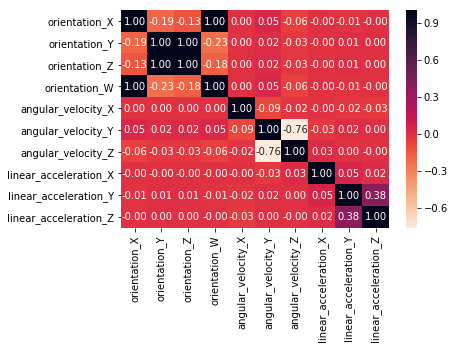

In [25]:
sns.heatmap(df_explore[robot_stats].corr(), cmap = 'rocket_r', annot = True, fmt = '.2f');

Summary:
- Orientation_X and Orientation_W are strongly correlated (1.00)
- Orientation_Y and Orientation_Z are strongly correlated (1.00)
- Angular_velocity_Y and Angular_velocity_Z are highly negatively correlated (-0.76)
- Linear_acceleration_Z and Linear_acceleration_Y are positively correlated (0.38)

In [27]:
def surface_allseries_subset(surface_type):
    surface_series = surface[surface['surface'] == surface_type]['series_id'].values[0]
    data_surface = pd.DataFrame()
    for i in range(len(surface_series)):
        subset = df_explore[df_explore['series_id']==surface_series[i]]
        data_surface = pd.concat([data_surface, subset], axis=0)
    return data_surface

In [28]:
def plot_stats_corr_for_surface(surface_type):
    subset = surface_allseries_subset(surface_type)
    sns.heatmap(subset[robot_stats].corr(), cmap = 'viridis', annot = True, fmt = '.2f');
    plt.title('Correlations for {} series'.format(surface_type),  fontsize=20);

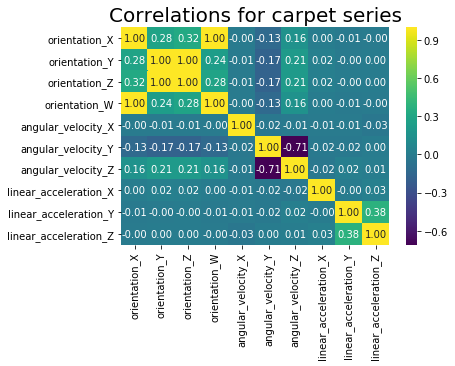

In [29]:
#Change surface type (e.g. 'carpet', 'concrete'...) to plot correlations for robot stat per surface
plot_stats_corr_for_surface('carpet');

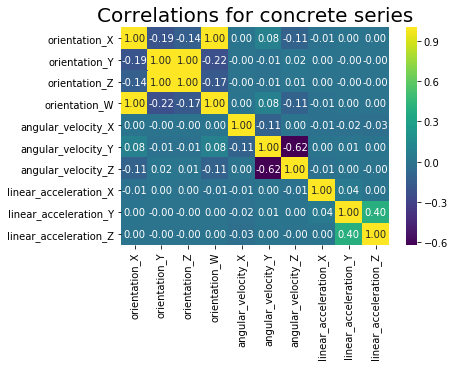

In [30]:
plot_stats_corr_for_surface('concrete');

## Mean values per surface for all series:

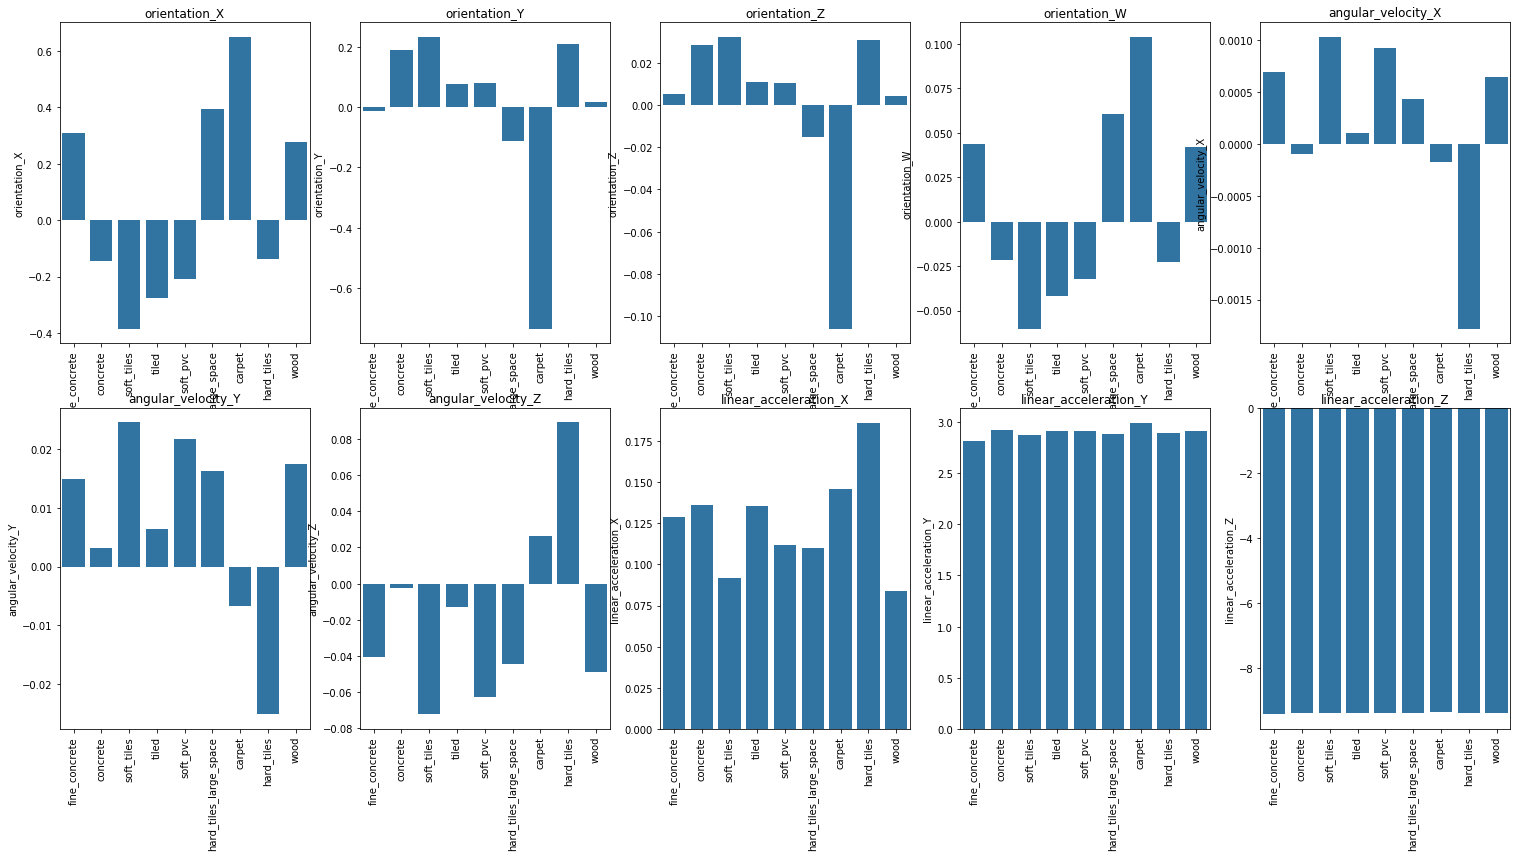

In [31]:
plt.figure(figsize=(26, 13))
for i,col in enumerate(df_explore.columns[3:13]):
    ax = plt.subplot(2,5,i+1)
    ax = plt.title(col)
    df_per_surface = df_explore.groupby(df_explore['surface']).mean()
    sns.barplot(targets, df_per_surface[col], color = base_color);
    plt.xticks(rotation=90);

## Standard deviation per surface for all series:

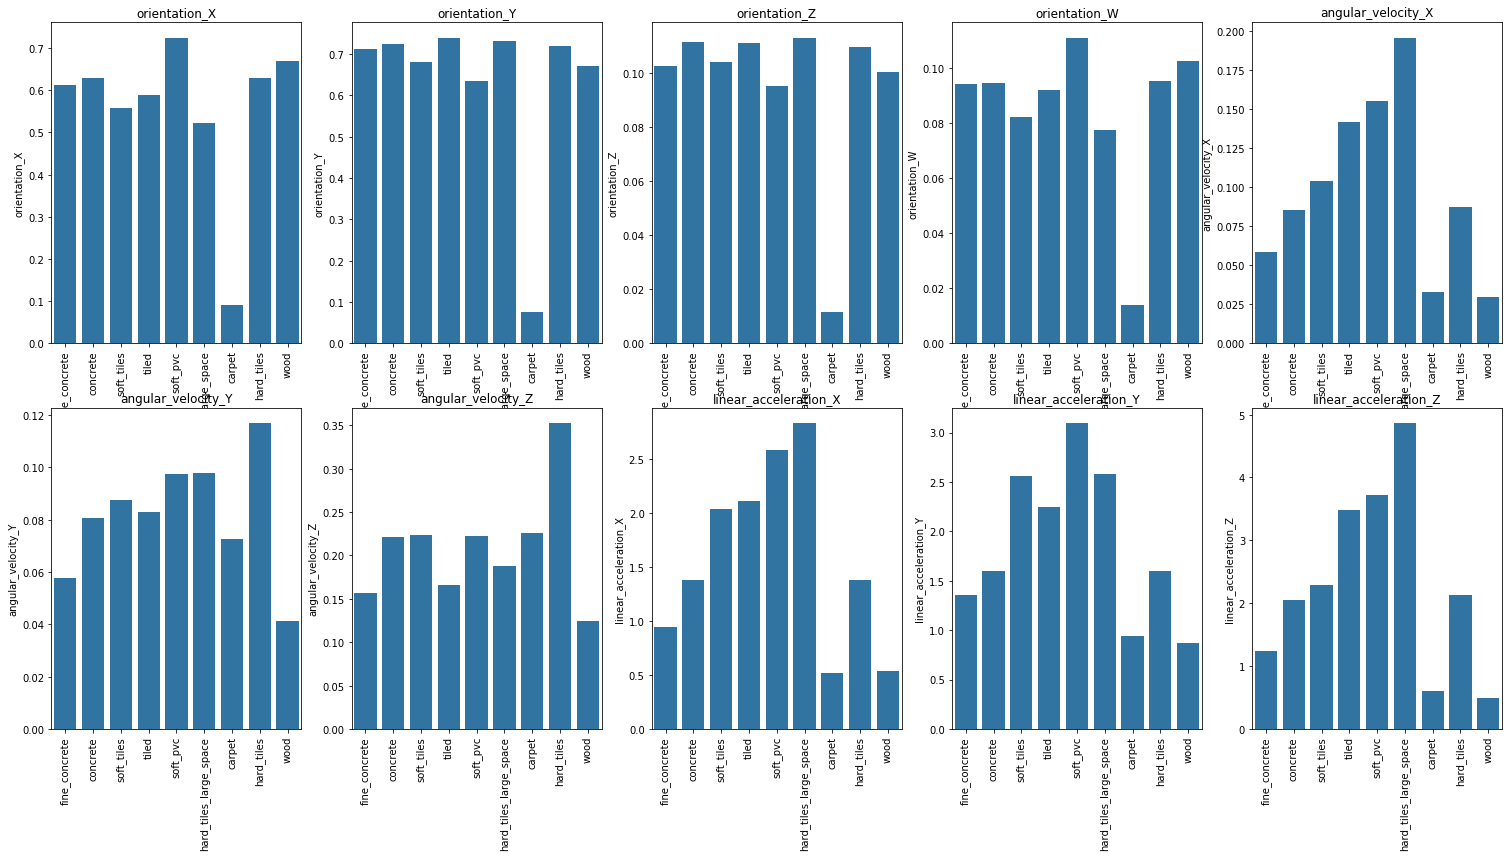

In [32]:
plt.figure(figsize=(26, 13))
for i,col in enumerate(df_explore.columns[3:13]):
    ax = plt.subplot(2,5,i+1)
    ax = plt.title(col)
    df_per_surface = df_explore.groupby(df_explore['surface']).std()
    sns.barplot(targets, df_per_surface[col], color = base_color);
    plt.xticks(rotation=90);

## Plotting raw data for each robot stat for ALL series per surface:

In [33]:
def plot_robot_stat_persurface(robot_stat):
    plt.figure(figsize=(13, 13))
    print(robot_stat)
    subset = df_explore[[robot_stat, 'surface', 'series_id']]
    for i, target in enumerate(targets):
        surface_subset = subset[subset['surface']==target]
        ax = plt.subplot(3,3,i+1)
        ax = plt.title(target)
        plt.plot(surface_subset[robot_stat]);
        if robot_stat in('orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W'):
            plt.ylim(-1.25,1.25)
        elif robot_stat in('angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z'):
            plt.ylim(-2, 2);
        else:
            plt.ylim(-75, 75);
        plt.xticks([], []);

linear_acceleration_Y


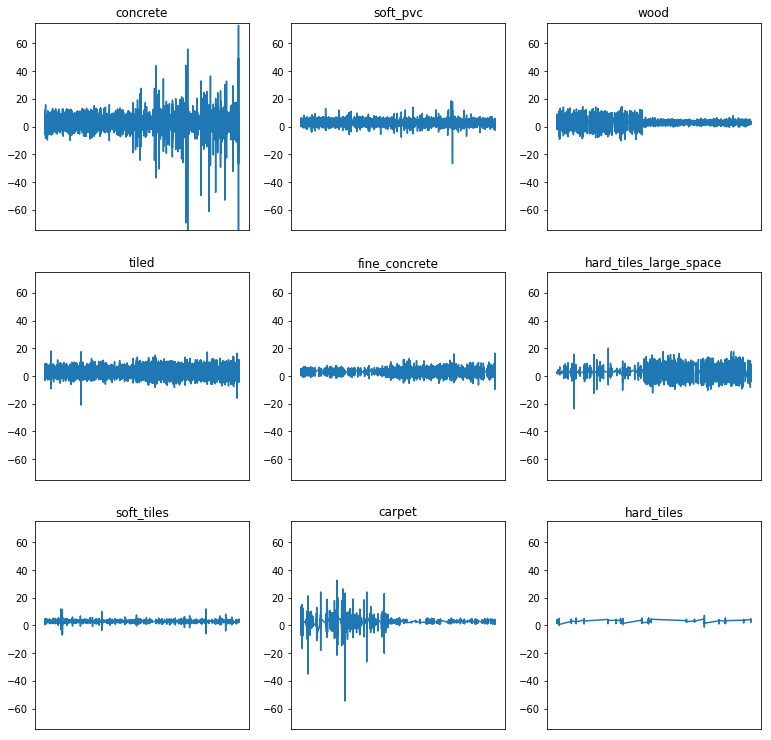

In [34]:
#plots all series for each surface
# change robot_stats values from 0 to 9
plot_robot_stat_persurface(robot_stats[8]);

# Modeling:

### Label encoding:

In [37]:
# encodes targets as numbers from 0 to 8
# to be used in supervised ML algorithms 
le = LabelEncoder()
y_train_ML = le.fit_transform(df_ytrain['surface'])
y_train_ML

array([2, 1, 1, ..., 2, 7, 5])

In [36]:
# encodes targets as dummies, but needs numerical categories (that's why used on top of y_train_ML)
# to be used in deep learning
y_train_keras = utils.to_categorical(y_train_ML)
y_train_keras

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Preparing X_train and X_test - running PCA and aggregating (mean, std) to the series level

In [39]:
def preparing_data_for_prediction(data):
    X = StandardScaler().fit_transform(data[robot_stats]) 
    pca = PCA(7)
    X_pca = pca.fit_transform(X)
    print("variance explained by pca components:", (pca.explained_variance_ratio_*100).astype(int))
    
    df_pca = pd.concat([pd.DataFrame(X_pca), data['series_id']], axis=1)
    X_train_mean = df_pca.groupby(data['series_id']).mean()
    X_train_std = df_pca.groupby(data['series_id']).std()
    X_train = pd.concat([X_train_mean, X_train_std], axis=1)
    X_train = X_train.drop(['series_id'], axis=1)
    
    return X_train

Summary: <br>
I chose 7 components because together they explain 93% of variation in the dataset. In the modeling part, I will use pca components aggregated to means and standard deviations for each serie to train and predict the floor types. <br>

In [40]:
X_train = preparing_data_for_prediction(df_explore)

variance explained by pca components: [23 18 15 13  9  9  6]


In [41]:
print(X_train.shape)
X_train.head()

(3810, 14)


,0,1,2,3,4,5,6,0,1,2,3,4,5,6
series_id,,,,,,,,,,,,,,
0,-0.011364,-1.195897,-1.725609,-0.029907,-0.009283,-0.053724,-0.019041,0.021076,0.240041,0.144814,0.620038,0.449790,0.469361,0.444344
1,-1.602035,-0.660606,-0.939664,0.089197,-0.043513,0.010245,0.043591,0.036565,0.418051,0.245146,0.942574,0.785232,0.587432,0.647522
2,0.594090,-1.286735,-1.578043,0.015562,-0.031947,0.009985,-0.013754,0.024401,0.274313,0.164418,0.758151,0.510820,0.404428,0.513077
3,-1.644242,-0.570703,-0.855220,0.131463,-0.003875,-0.041539,0.066338,0.047590,0.393217,0.256434,1.894310,1.511048,0.815705,1.305396
4,-1.705619,0.302744,-1.070548,0.053574,-0.123329,0.082906,-0.015639,0.017816,0.188275,0.122678,0.456604,0.378784,0.237968,0.387006


Summary: the final X_train dataset has 14 variables - 7 aggregated pca means for each serie and 7 aggregated pca standard deviations for each serie. We are ready to run the models!

In [42]:
X_test = preparing_data_for_prediction(df_Xtest)

variance explained by pca components: [21 18 17 14 10  9  6]


In [43]:
print(X_test.shape)
X_test.head()

(3816, 14)


,0,1,2,3,4,5,6,0,1,2,3,4,5,6
series_id,,,,,,,,,,,,,,
0,-1.325167,1.688925,-0.453536,-0.004245,-0.017930,0.020554,0.019087,0.158260,0.069340,0.394078,0.856810,0.715666,0.716430,0.481724
1,-1.177482,-1.522007,-0.748786,-0.006849,0.078941,0.012181,-0.003798,0.102834,0.044170,0.251572,0.827605,0.643359,0.504837,0.656844
2,0.630659,-1.638348,-0.102142,-0.000953,-0.056941,-0.043233,-0.026054,0.234640,0.102695,0.579237,1.105561,1.013586,1.181606,0.706016
3,1.332834,-1.102171,-0.030660,-0.027861,0.020687,-0.015718,-0.019273,0.051037,0.023381,0.121670,0.198549,0.173784,0.171767,0.130505
4,0.202240,-1.813419,0.820242,0.092084,0.084170,-0.076807,0.049158,0.023763,0.010478,0.098156,0.245764,0.154075,0.128908,0.216551


## Supervised ML algorithms: 
### Bagging, RandomForest, GradientDescent and AdaBoost Classifier

In [44]:
# Split data into training and testing sets for validation
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, 
                                                    y_train_ML, 
                                                    test_size = 0.3, 
                                                    random_state = 7)

In [45]:
X_train_val.shape

(2667, 14)

In [46]:
X_test_val.shape

(1143, 14)

In [47]:
# Initialize models
clf_rf = RandomForestClassifier(n_estimators = 400, random_state = 432)
clf_Ada = AdaBoostClassifier(n_estimators = 400, random_state = 432)
clf_gradient = GradientBoostingClassifier(n_estimators = 400, random_state = 432)
clf_bagging = BaggingClassifier(n_estimators = 400, random_state = 432)

In [48]:
# Fit models
clf_rf.fit(X_train_val, y_train_val)
clf_Ada.fit(X_train_val, y_train_val)
clf_gradient.fit(X_train_val, y_train_val)
clf_bagging.fit(X_train_val, y_train_val)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=400, n_jobs=None, oob_score=False, random_state=432,
         verbose=0, warm_start=False)

In [49]:
# Predict using test data
pred_rf = clf_rf.predict(X_test_val)
pred_Ada = clf_Ada.predict(X_test_val)
pred_gradient = clf_gradient.predict(X_test_val)
pred_bagging = clf_bagging.predict(X_test_val)

In [50]:
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (numpy array or pandas series)
    preds - the predictions for those values from some model (numpy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the accuracy
    '''
    if model_name == None:
        print('Accuracy score: ', format(accuracy_score(y_true, preds)))
    
    else:
        print('Accuracy score for ' + model_name + ' :' , format(accuracy_score(y_true, preds)))



In [51]:
# Print scores
print_metrics(y_test_val, pred_rf, "Random Forest")
print_metrics(y_test_val, pred_Ada, "AdaBoost")
print_metrics(y_test_val, pred_gradient, "Gradient")
print_metrics(y_test_val, pred_bagging, "Bagging")

Accuracy score for Random Forest : 0.7751531058617673
Accuracy score for AdaBoost : 0.3937007874015748
Accuracy score for Gradient : 0.7882764654418197
Accuracy score for Bagging : 0.8066491688538933


In [52]:
confusion_matrix(y_test_val,pred_rf)

array([[ 20,   9,  10,   0,   1,   9,   6,   2,   8],
       [  1, 184,   7,   0,   4,  12,   1,   2,   5],
       [  1,  12,  65,   0,   4,   8,   2,   7,  10],
       [  0,   1,   0,   1,   0,   2,   2,   0,   2],
       [  1,  12,   4,   0,  73,   2,   1,   2,   4],
       [  0,  10,   4,   0,   0, 188,   3,   1,   3],
       [  0,   1,   0,   0,   0,   9,  82,   0,   4],
       [  1,  10,   5,   0,   0,   5,   3, 126,   3],
       [  1,   7,   3,   0,   0,  20,   4,   6, 147]])

In [53]:
predicted = np.zeros((df_Xtest.shape[0],9))
predicted = clf_bagging.predict(X_test)
predicted

array([8, 8, 1, ..., 5, 7, 8])

In [55]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['surface'] = le.inverse_transform(predicted)
submission.to_csv('submission.csv', index=False)
submission.head(10)

,series_id,surface
0,0,wood
1,1,wood
2,2,concrete
3,3,wood
4,4,soft_tiles
5,5,concrete
6,6,concrete
7,7,fine_concrete
8,8,wood
9,9,wood


In [56]:
submission.shape

(3816, 2)

# Deep Learning Model in Keras

In [58]:
# Building the model
xor = Sequential()

# Add required layers
xor.add(Dense(units = 3810, input_dim=14))
xor.add(Dropout(0.2))
xor.add(Activation('relu'))
xor.add(Dense(units = 128))
xor.add(Dropout(.1))
xor.add(Activation('relu'))
xor.add(Dense(units = 9))
xor.add(Activation('softmax'))

# Specify loss as "binary_crossentropy", optimizer as "adam",
# and add the accuracy metric
xor.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Uncomment this line to print the model architecture
xor.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3810)              57150     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3810)              0         
_________________________________________________________________
activation_1 (Activation)    (None, 3810)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               487808    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_2 (Activat

In [60]:
# Fitting the model
fitted_model = xor.fit(X_train, y_train_keras, batch_size=32, epochs=100, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3810/3810 [==============================] - 2s 483us/step - loss: 1.5137 - acc: 0.4465
Epoch 2/100
3810/3810 [==============================] - 1s 317us/step - loss: 1.2388 - acc: 0.5472
Epoch 3/100
3810/3810 [==============================] - 1s 301us/step - loss: 1.1206 - acc: 0.5974
Epoch 4/100
3810/3810 [==============================] - 1s 286us/step - loss: 1.0264 - acc: 0.6341
Epoch 5/100
3810/3810 [==============================] - 1s 276us/step - loss: 0.9567 - acc: 0.6543
Epoch 6/100
3810/3810 [==============================] - 1s 283us/step - loss: 0.8889 - acc: 0.6811
Epoch 7/100
3810/3810 [==============================] - 1s 288us/step - loss: 0.8364 - acc: 0.6995
Epoch 8/100
3810/3810 [==============================] - 1s 278us/step - loss: 0.8396 - acc: 0.6955
Epoch 9/100
3810/3810 [==============================] - 1s 298us/step - loss: 0.7635 - acc: 0.7299
Epoch 10/100
3810/3810 [============================

3810/3810 [==============================] - 1s 290us/step - loss: 0.1922 - acc: 0.9304
Epoch 80/100
3810/3810 [==============================] - 1s 283us/step - loss: 0.2046 - acc: 0.9205
Epoch 81/100
3810/3810 [==============================] - 1s 291us/step - loss: 0.1872 - acc: 0.9320
Epoch 82/100
3810/3810 [==============================] - 1s 278us/step - loss: 0.1892 - acc: 0.9310
Epoch 83/100
3810/3810 [==============================] - 1s 282us/step - loss: 0.1866 - acc: 0.9304
Epoch 84/100
3810/3810 [==============================] - 1s 286us/step - loss: 0.1971 - acc: 0.9218
Epoch 85/100
3810/3810 [==============================] - 1s 294us/step - loss: 0.1861 - acc: 0.9294
Epoch 86/100
3810/3810 [==============================] - 1s 288us/step - loss: 0.1703 - acc: 0.9367
Epoch 87/100
3810/3810 [==============================] - 1s 283us/step - loss: 0.1795 - acc: 0.9315
Epoch 88/100
3810/3810 [==============================] - 1s 285us/step - loss: 0.1810 - acc: 0.9307
Epo

In [63]:
predicted = xor.predict_classes(X_test)
predicted

array([1, 7, 7, ..., 5, 7, 4])

In [64]:
submission2 = pd.read_csv('../input/sample_submission.csv')
submission2['surface'] = le.inverse_transform(predicted)
submission2.to_csv('submission.csv', index=False)
submission2.head(10)

,series_id,surface
0,0,concrete
1,1,tiled
2,2,tiled
3,3,soft_tiles
4,4,soft_tiles
5,5,concrete
6,6,concrete
7,7,concrete
8,8,wood
9,9,soft_tiles
